가위바위보 분류기

먼저 가위바위보 분류기를 만드는데 필요한 라이브러리를 불러옵니다.



In [1]:
from PIL import Image
import glob
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!



224x224의 원본이미지 파일의 크기를 28x28으로 바꾸어주고 저장합니다.

이미지가 저장된 디렉토리의 위치를 정확하게 입력해야 이미지를 불러옵니다.



In [2]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료")

3507  images to be resized.
3507  images resized.
가위 이미지 resize 완료!
3612  images to be resized.
3612  images resized.
바위 이미지 resize 완료
3542  images to be resized.
3542  images resized.
보 이미지 resize 완료



resize를 마친 이미지와 라벨(가위: 0, 바위: 1, 보: 2) 데이터(정답 데이터)를 담을 행렬을 생성합니다.

이미지의 개수는 총 10661개이므로 number_of_data=10661으로 입력합니다.

resize를 28x28으로 했기 때문에 img_size=28, 이미지가 흑백이 아닌 컬러이기에 color=3입니다.

또한, 이미지 resize를 할 때처럼 이미지의 디렉토리 위치를 확인해줍니다.

이후 .shape를 통해서 train data가 잘 담겼는지 확인합니다.



In [3]:
import numpy as np

def load_data(img_path, number_of_data=10661):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))


학습데이터(x_train)의 이미지 개수는 10661 입니다.
x_train shape: (10661, 28, 28, 3)
y_train shape: (10661,)



train data를 불러와서 한 번 확인해봅니다.

저는 무작위로 x_train에 7을 넣어서 확인했습니다.



라벨:  0


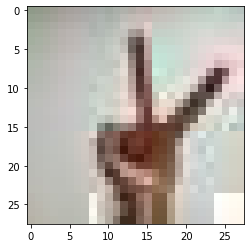

In [4]:
plt.imshow(x_train[7])
print('라벨: ', y_train[0])


train data가 잘 담긴 것을 확인했으니, 딥러닝 네트워크를 설계합니다.

keras 라이브러리를 통해서 만들어줍니다.

28x28 사이즈의 컬러 이미지이기 때문에 input_shape=(28,28,3)으로 입력합니다.

가위바위보 이미지 분류의 결과는 가위, 바위, 보 3가지이기 때문에 최종 분류기의 클래스 수를 3으로 입력합니다.



In [5]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                25616     
_________________________________________________________________
dense_1 (Dense)              (No


딥러닝 네트워크를 설계한 다음에는 딥러닝 네트워크를 학습시킵니다.

epoch는 10661개의 데이터를 학습시키는 반복 학습시키는 수를 말합니다.

인식 정확도를 높이기 위해서 저는 20번 반복 학습시켰습니다.



In [6]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20)

Epoch 1/20
334/334 [==============================] - 4s 3ms/step - loss: 2.7846 - accuracy: 0.4819
Epoch 2/20
334/334 [==============================] - 1s 3ms/step - loss: 0.6917 - accuracy: 0.6623
Epoch 3/20
334/334 [==============================] - 1s 3ms/step - loss: 0.5260 - accuracy: 0.7398
Epoch 4/20
334/334 [==============================] - 1s 3ms/step - loss: 0.4465 - accuracy: 0.7800
Epoch 5/20
334/334 [==============================] - 1s 3ms/step - loss: 0.3811 - accuracy: 0.8207
Epoch 6/20
334/334 [==============================] - 1s 3ms/step - loss: 0.3128 - accuracy: 0.8555
Epoch 7/20
334/334 [==============================] - 1s 3ms/step - loss: 0.2535 - accuracy: 0.8847
Epoch 8/20
334/334 [==============================] - 1s 3ms/step - loss: 0.2138 - accuracy: 0.9130
Epoch 9/20
334/334 [==============================] - 1s 3ms/step - loss: 0.1670 - accuracy: 0.9330
Epoch 10/20
334/334 [==============================] - 1s 3ms/step - loss: 0.1401 - accuracy: 0.9431


이제 test data를 통해서 위의 가위바위보 분류기가 잘 만들어졌는지, 분류의 정확도는 얼마나 되는지를 확인해봅니다.

train data를 불러올 때와 같이 test data의 이미지를 28x28으로 resize한 이후 저장합니다.

또한 이미지가 저장된 디렉토리의 위치를 정확하게 입력해야 합니다.



In [7]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료")

900  images to be resized.
900  images resized.
가위 이미지 resize 완료!
900  images to be resized.
900  images resized.
바위 이미지 resize 완료
900  images to be resized.
900  images resized.
보 이미지 resize 완료



가위 900개, 바위 900개, 보 900개의 이미지를 resize 했습니다.

train data를 담는 행렬을 만들때 처럼, 총 2700개의 이미지이기에 number_of_data=2700으로 입력합니다.

이미지의 사이즈가 28x28이고 컬러 이미지이기에 img_size=28, color=3 입니다.




In [8]:
def load_data(img_path, number_of_data=2700):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))



학습데이터(x_test)의 이미지 개수는 2700 입니다.
x_test shape: (2700, 28, 28, 3)
y_test shape: (2700,)



이제 test data가 담긴 것을 확인했습니다.

가위바위보 분류기가 잘 작동하는 지를 확인하기 위해서 test data의 정확도를 확인해봅니다.

정확도는 아래 보는 것처럼 0.6448 가 나왔습니다.



In [9]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

85/85 - 0s - loss: 3.8374 - accuracy: 0.6448
test_loss: 3.8373818397521973 
test_accuracy: 0.6448147892951965





회고


처음으로 진행하는 Exploration의 프로젝트는 생각보다 쉽지 않았다.

대부분의 코드가 앞선 예제에서 주어져 있었고 조금만 수정하면 되어 다행이었지만, 데이터셋을 구하고 하는 점이 까다로웠다.


1차 시도


처음에 train data를 내 손으로 찍은 가위 100장, 바위 100장 보 100장 총 300장 훈련시켰다.

데이터의 수가 적으니 epoch가 3~4가 넘어가니 정확도가 1이 넘어갔고 오버피팅이 일어났다.

test data는 아이펠에서 제공한 300개의 데이터를 사용했다.

train data의 개수가 적고 오버피팅이 일어나서 그런지 test의 정확도는 0.3333이 계속 나왔다.




2차 시도


train data의 개수가 적으면 test의 정확도가 낮게 나온다고 생각해서 train data를 가위, 바위, 보 각 5000개, 총 15000개로 늘렸다.

여기서 train data는 전부 다 내 손 사진이었다.

train data의 수가 50배 정도 늘었지만, test data의 정확도는 0.4xx 정도로 그다지 높아지지 않았다.

그 이유는 train data가 모두 내 손으로 찍어서 다양성이 부족했고, 15000개의 train data의 개수에 비해서 test data는 100개로 적었다.

대부분 train data와 test data의 비율은 8:2, 7:3 정도인데 나의 경우 9.9:0.1 정도였다.

train data와 test data의 다양성이 부족하고 비율도 맞지 않은 점이 문제이기에 수정해야만 했다.



3차 시도


train data를 15000장의 내 사진이 아니라 내 손 사진에 다른 사람들의 사진을 더해서 다양하게 만들어줬다.

이렇게 train data를 다양화시키니 오버피팅이 발생하지 않았다.

test data도 아이펠에서 제공한 사진에 더해서 2700개로 다양화시켰다.

이렇게 바꾸니 train data와 test data의 비율이 7.5:2.5 정도였고 적절한 비율이었다.

test data의 정확도가 0.5xx 정도가 나왔다.

조금 더 정확도를 높이기 위해서 딥러닝 네트워크 설계의 Conv2D의 수를 높이고 epoch의 횟수를 높여줬다.

그러니 test data가 0.6448로 3분의 2 정도는 식별할 수 있는 수준이 되었다.




저는 이렇게 3번 정도 데이터셋을 수정하며 가위바위보 분류기의 정확도를 높였습니다.

당연한 이야기이겠으나 이번 프로젝트를 통해서 train data와 test data의 다양성 및 개수의 중요함도 알게 되었고, 

데이터를 구하는 것 자체도 어렵다는 점을 몸소 체험하게 되었습니다.

다행인 점은 데이터를 수정하며 정확도가 높아지니 뿌듯하고 기분도 좋았다는 것입니다.

그래도 쉽지 않네요....


